In [45]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

In [46]:
from matplotlib import pyplot as plt
from matplotlib import pylab as plb
from matplotlib import cm as cm
%matplotlib inline

In [47]:
train = pd.read_csv("./../cleaning/train_clean.csv", encoding= "utf_8")
test = pd.read_csv("./../cleaning/test_clean.csv", encoding= "utf_8")
# train_test = pd.concat
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43.0,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34.0,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43.0,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89.0,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77.0,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


Сравним несколько моделей xgboost, полученных на различных множествах параметров.

In [48]:
all_feature_cols = test.columns

In [49]:
building_columns = ['max_floor', 'material', 'build_year', 'ID_metro', 'metro_min_avto', 'metro_km_avto', 'metro_min_walk', 
            'metro_km_walk', 'kindergarten_km', 'school_km', 'park_km', 'green_zone_km', 'industrial_km', 'water_treatment_km', 
            'cemetery_km', 'incineration_km', 'railroad_station_walk_km', 'railroad_station_walk_min', 'ID_railroad_station_walk',
            'railroad_station_avto_km', 'railroad_station_avto_min', 'ID_railroad_station_avto', 'public_transport_station_km',
            'public_transport_station_min_walk', 'water_km', 'water_1line', 'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km',
            'kremlin_km', 'big_road1_km', 'ID_big_road1', 'big_road1_1line', 'big_road2_km', 'ID_big_road2', 'railroad_km', 
            'railroad_1line', 'zd_vokzaly_avto_km', 'ID_railroad_terminal', 'bus_terminal_avto_km', 'ID_bus_terminal', 
            'oil_chemistry_km', 'nuclear_reactor_km', 'radiation_km', 'power_transmission_line_km', 'thermal_power_plant_km',
            'ts_km', 'big_market_km', 'market_shop_km', 'fitness_km', 'swim_pool_km', 'ice_rink_km', 'stadium_km', 'basketball_km',
            'hospice_morgue_km', 'detention_facility_km', 'public_healthcare_km', 'university_km', 'workplaces_km', 
            'shopping_centers_km', 'office_km', 'additional_education_km', 'preschool_km', 'big_church_km', 'church_synagogue_km',
            'mosque_km', 'theater_km', 'museum_km', 'exhibition_km', 'catering_km', 'ecology', 
           ]

In [50]:
district_columns = ['raion_popul','sub_area', 'green_zone_part', 'indust_part', 'children_preschool', 'preschool_quota', 
            'preschool_education_centers_raion', 'children_school', 'school_quota', 'school_education_centers_raion',
           'school_education_centers_top_20_raion', 'hospital_beds_raion', 'healthcare_centers_raion', 'university_top_20_raion',
            'sport_objects_raion', 'additional_education_raion', 'culture_objects_top_25', 'culture_objects_top_25_raion', 
            'shopping_centers_raion', 'office_raion', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion',
            'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion',
            'full_all', 'male_f', 'female_f', 'young_all', 'young_male', 'young_female', 'work_all', 'work_male', 'work_female',
            'ekder_all', 'ekder_male','ekder_female', '0_6_all', '0_6_male', '0_6_female', '7_14_all', '7_14_male', '7_14_female',
            '0_17_all', '0_17_male', '0_17_female', '16_29_all', '16_29_male', '16_29_female', '0_13_all', '0_13_male', 
            '0_13_female', 'raion_build_count_with_material_info', 'build_count_block', 'build_count_wood', 'build_count_frame',
            'build_count_brick','build_count_monolith', 'build_count_panel', 'build_count_foam', 'build_count_slag', 
            'build_count_mix', 'raion_build_count_with_builddate_info', 'build_count_before_1920', 'build_count_1921-1945',
            'build_count_1946-1970', 'build_count_1971-1995', 'build_count_after_1995',
           ]

In [51]:
unknown_columns = ['product_type','area_m', 'green_part_500', 'prom_part_500', 'office_count_500', 'office_sqm_500', 
           'trc_count_500', 'trc_sqm_500', 'cafe_count_500', 'cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg',
           'cafe_avg_price_500', 'cafe_count_500_na_price', 'cafe_count_500_price_500', 'cafe_count_500_price_1000', 
           'cafe_count_500_price_1500', 'cafe_count_500_price_2500', 'cafe_count_500_price_4000', 'cafe_count_500_price_high',
           'big_church_count_500', 'church_count_500', 'mosque_count_500', 'leisure_count_500', 'sport_count_500', 
           'market_count_500', 'green_part_1000', 'prom_part_1000', 'office_count_1000', 'office_sqm_1000', 'trc_count_1000',
           'trc_sqm_1000', 'cafe_count_1000', 'cafe_sum_1000_min_price_avg', 'cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000',
           'cafe_count_1000_na_price', 'cafe_count_1000_price_500', 'cafe_count_1000_price_1000', 'cafe_count_1000_price_1500',
           'cafe_count_1000_price_2500','cafe_count_1000_price_4000','cafe_count_1000_price_high','big_church_count_1000',
           'church_count_1000','mosque_count_1000','leisure_count_1000','sport_count_1000','market_count_1000','green_part_1500',
           'prom_part_1500','office_count_1500','office_sqm_1500','trc_count_1500','trc_sqm_1500','cafe_count_1500',
           'cafe_sum_1500_min_price_avg','cafe_sum_1500_max_price_avg','cafe_avg_price_1500','cafe_count_1500_na_price',
           'cafe_count_1500_price_500','cafe_count_1500_price_1000','cafe_count_1500_price_1500','cafe_count_1500_price_2500',
           'cafe_count_1500_price_4000','cafe_count_1500_price_high','big_church_count_1500','church_count_1500',
           'mosque_count_1500','leisure_count_1500', 'sport_count_1500','market_count_1500','green_part_2000','prom_part_2000',
           'office_count_2000','office_sqm_2000','trc_count_2000','trc_sqm_2000','cafe_count_2000','cafe_sum_2000_min_price_avg',
           'cafe_sum_2000_max_price_avg','cafe_avg_price_2000','cafe_count_2000_na_price','cafe_count_2000_price_500',
           'cafe_count_2000_price_1000','cafe_count_2000_price_1500','cafe_count_2000_price_2500','cafe_count_2000_price_4000',
           'cafe_count_2000_price_high','big_church_count_2000', 'church_count_2000','mosque_count_2000','leisure_count_2000',
           'sport_count_2000','market_count_2000','green_part_3000','prom_part_3000','office_count_3000','office_sqm_3000',
           'trc_count_3000', 'trc_sqm_3000','cafe_count_3000','cafe_sum_3000_min_price_avg','cafe_sum_3000_max_price_avg',
           'cafe_avg_price_3000','cafe_count_3000_na_price','cafe_count_3000_price_500','cafe_count_3000_price_1000',
           'cafe_count_3000_price_1500','cafe_count_3000_price_2500', 'cafe_count_3000_price_4000','cafe_count_3000_price_high',
           'big_church_count_3000','church_count_3000','mosque_count_3000','leisure_count_3000','sport_count_3000',
           'market_count_3000','green_part_5000','prom_part_5000', 'office_count_5000','office_sqm_5000','trc_count_5000',
           'trc_sqm_5000','cafe_count_5000','cafe_sum_5000_min_price_avg','cafe_sum_5000_max_price_avg','cafe_avg_price_5000',
           'cafe_count_5000_na_price','cafe_count_5000_price_500', 'cafe_count_5000_price_1000','cafe_count_5000_price_1500',
           'cafe_count_5000_price_2500','cafe_count_5000_price_4000','cafe_count_5000_price_high','big_church_count_5000',
           'church_count_5000','mosque_count_5000','leisure_count_5000','sport_count_5000', 'market_count_5000',
          ]

In [52]:
flat_columns = ['full_sq','life_sq', 'floor', 'num_room', 'kitch_sq', 'state',  ]

In [53]:
def xgbModel(cols):
    for f in cols:
        if train[f].dtype=='object':
            lbl = LabelEncoder()
            lbl.fit(list(train[f].values)) 
            train[f] = lbl.transform(list(train[f].values))

    train_y = train.price_doc.values
    train_X = train.loc[:,cols]

    xgb_params = {
        'eta': 0.05,
        'max_depth': 8,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'silent': 1
    }
    
    dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
    model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)
    # plot the important features #
#     fig, ax = plt.subplots(figsize=(12,18))
#     xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
#     plt.show()

In [54]:
from sklearn.preprocessing import Imputer, LabelEncoder

In [55]:
def xgbModel2(cols):
    for f in cols:
        if train[f].dtype=='object':
            lbl = LabelEncoder()
            lbl.fit(list(train[f].values)) 
            train[f] = lbl.transform(list(train[f].values))

    X_train, X_test, y_train, y_test = train_test_split(train.loc[:,cols], train.price_doc.values, test_size=0.3)
    
    X_train = pd.DataFrame(X_train)
    X_train.columns = cols
    
    X_test = pd.DataFrame(X_test)
    X_test.columns = cols
    
    
    xgb_params = {
        'eta': 0.05,
        'max_depth': 5,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'silent': 1
    }
    
    dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns.values)
    model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)
    
    y_pred = model.predict(xgb.DMatrix(X_test))
    accuracy = mean_absolute_error(y_test, y_pred)
    print 'mae'
    print round(accuracy, -4)
    print 'percent'
    print np.mean(np.absolute((y_pred- y_test)/y_pred))
#     xgb.plot_tree(model, num_trees=1)
#     fig = plt.gcf()
#     fig.set_size_inches(300, 300)
#     fig.savefig('tree.png')
#     plt.ylabel('actual', fontsize=12)
#     plt.xlabel('predicted', fontsize=12)
#     plt.show()
    
    # plot the important features #
#     fig, ax = plt.subplots(figsize=(12,18))
#     xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
#     plt.show()
    return model

In [56]:
all_feature_model = xgbModel2(all_feature_cols)

mae
1470000.0
percent
0.19280884441336504


In [57]:
flat_model = xgbModel2(cols=flat_columns)

mae
1980000.0
percent
0.2664223263088964


In [58]:
building_model = xgbModel2(cols=building_columns)

mae
2200000.0
percent
0.29305579640406004


In [59]:
unknown_model = xgbModel2(cols=unknown_columns)

mae
2330000.0
percent
0.31214930348836484


In [60]:
district_model = xgbModel2(cols=district_columns)

mae
2530000.0
percent
0.3342430156595715


In [61]:
def plotPrediction(y_predicted, y_real):
    plt.scatter(y_predicted, y_real)
    plt.ylabel('predicted price', fontsize=12)
    plt.xlabel('actual price', fontsize=12)
    plt.show()
    print 'MAE = {}'.format(round(mae(Y_PRED)), 3)
    print 'percentage deviation = {}'.format(round(100*np.mean(np.absolute((y_predicted - y_real)/y_predicted))), 3)

In [62]:
def predict(cols, model):
    y_pred = model.predict(xgb.DMatrix(train.loc[:,cols]))
    plotPrediction(y_pred, train.price_doc.values)
    return y_pred

In [63]:
def mae(predicted):
    return mean_absolute_error(train.price_doc.values, predicted)

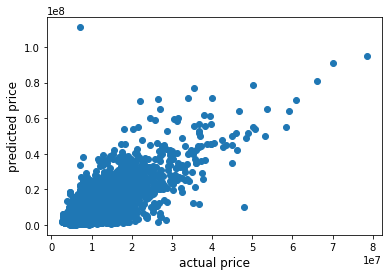

MAE = 1498306.0
percentage deviation = 26.0


1935539.3735272882

In [64]:
mae(predict(flat_columns, flat_model))

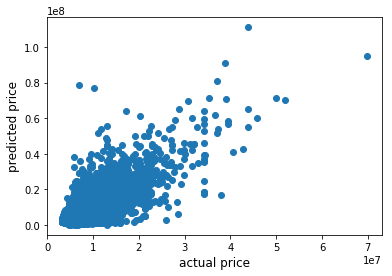

MAE = 1498306.0
percentage deviation = 28.0


2127340.5079255686

In [65]:
mae(predict(building_columns, building_model))

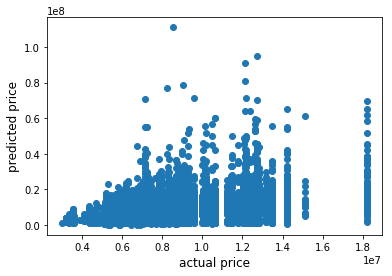

MAE = 1498306.0
percentage deviation = 33.0


2476549.6637540613

In [66]:
mae(predict(district_columns, district_model))

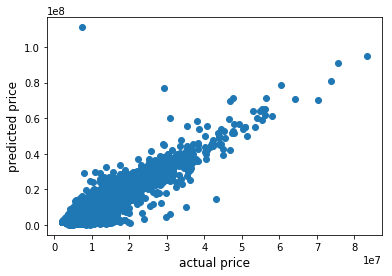

MAE = 1498306.0
percentage deviation = 19.0


1362843.5947130057

In [67]:
mae(predict(all_feature_cols, all_feature_model))

Linear model

In [68]:
from sklearn import linear_model
from sklearn.linear_model import Ridge

In [69]:
linear_model = Ridge (alpha = .5)

In [70]:
Y = train.price_doc.values
Y.size

30471

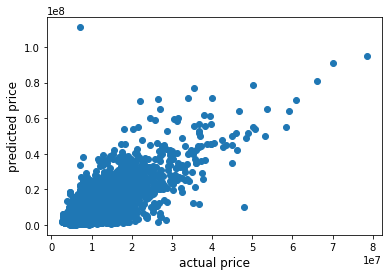

MAE = 1498306.0
percentage deviation = 26.0


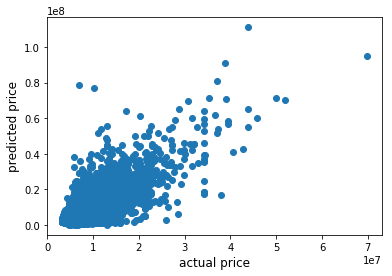

MAE = 1498306.0
percentage deviation = 28.0


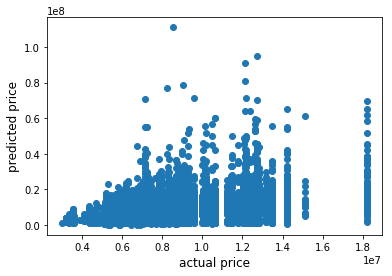

MAE = 1498306.0
percentage deviation = 33.0


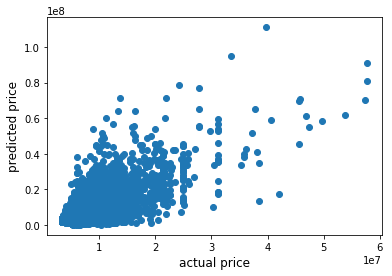

MAE = 1498306.0
percentage deviation = 30.0


121884

In [71]:
X = np.zeros((30471, 4))
a = predict(flat_columns, flat_model)
b = predict(building_columns, building_model)
c = predict(district_columns, district_model)
d = predict(unknown_columns, unknown_model)
for i in range (0, a.size):
    X[i] = [a[i], b[i], c[i], d[i]]
X.size

In [72]:
linear_model.fit(X, Y)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [73]:
Y_PRED = linear_model.predict(X)

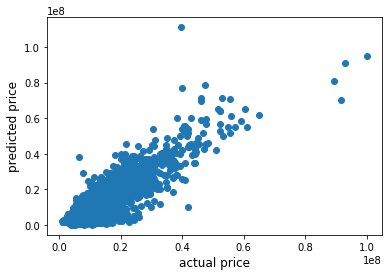

MAE = 1500124.0
percentage deviation = 20.0


In [74]:
plotPrediction(Y_PRED, Y)